In [2]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v3 Group single std scaler

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

v0 Feed second input (median and stdev) to the neural network after the CNN part.

v3 Each group use the 

Test on stage 2 data.

Ensemble: automatically evaluate the same model 5 times

Original model: 'model_10_Modified_CNN_2_Median_x_Fib_y'

In [118]:
model_name = 'model_10_Modified_CNN_3_single_Std_scaler'

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [5]:
train_file = 'train_2.csv'

In [6]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)

In [7]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,37,58,25,23,25,47,44,26,24,21


In [8]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object', length=793)

In [9]:
visits_dtype = {d: np.float32 for d in input_df_dates}

In [10]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_2.csv ... done!


In [11]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [12]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 794 entries, Page to 2017-08-31
dtypes: float32(793), object(1)
memory usage: 439.9+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [13]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [14]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [15]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [16]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [17]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

In [18]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [19]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [20]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

In [21]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [22]:
weekday(X_input_first_day), weekday(X_output_first_day)

(4, 4)

Should be the same

#### Y

In [23]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [24]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

In [25]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [26]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [27]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

In [28]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [29]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(4, 4)

Should be the same

#### Z

Z_input_dates = input_df_dates[-test_length-364*2:y_length-test_length-364*2]; Z_input_dates

Z_input_first_day = Z_input_dates[0]
Z_input_final_day = Z_input_dates[-1]
Z_input_first_day, Z_input_final_day

daydiff(Z_input_first_day, Z_input_final_day)  # should be 1 - y_length

#Z for output set
Z_output_dates = Y_input_dates
Z_output_dates

Z_output_first_day = Z_output_dates[0]
Z_output_final_day = Z_output_dates[-1]
Z_output_first_day, Z_output_final_day

daydiff(Z_output_first_day, Z_output_final_day)  # should be 1 - y_length

weekday(Z_input_first_day), weekday(Z_output_first_day)

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [30]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [31]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [32]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [33]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [34]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [35]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [36]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [37]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [38]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

In [39]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

380

We will use this as the center and part of the result

In [40]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [41]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [42]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [43]:
X_input_log = log(X_input_raw)  # Contain nan
Y_input_log = log(Y_input_raw)
X_output_log = log(X_output_raw)
if test_length:
    Y_output_log = log(Y_output_raw)

In [44]:
X_input_log

array([[ 1.20412004,  1.47712123,  1.27875364, ...,  1.27875364,
         1.38021123,  1.11394334],
       [ 1.36172783,  1.36172783,  1.82607484, ...,  1.39794004,
         1.23044896,  1.20412004],
       [ 0.84509802,  0.60206002,  0.30103001, ...,  0.77815127,
         0.30103001,  0.69897002],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

X_input_log = log(X_input_num)
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [45]:
print(X_input_log.shape, Y_input_log.shape, X_output_log.shape)
if test_length: print(Y_output_log.shape)

(145063, 63) (145063, 63) (145063, 63)
(145063, 63)


#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

### Computer Median

In [55]:
# Option 1: Including nan
input_median = np.median(np.nan_to_num(X_input_log), axis=-1)#.reshape(-1,1)
output_median = np.median(np.nan_to_num(X_output_log), axis=-1)#.reshape(-1,1)

# Option 2: Not including nan
#input_median = np.nan_to_num(np.nanmedian(X_input_log, axis=-1))#.reshape(-1,1)
#output_median = np.nan_to_num(np.nanmedian(X_output_log, axis=-1))#.reshape(-1,1)

# Option 3: Use Fib median instead
#input_median = fib_input_median
#output_median = fib_output_median

### Compute Stdev

In [48]:
default_stdev = 0.17

In [56]:
# Option 1: Including nan
input_stdev = np.std(np.nan_to_num(X_input_log), axis=-1)#.reshape(-1,1)
output_stdev = np.std(np.nan_to_num(X_output_log), axis=-1)#.reshape(-1,1)

# Option 2: Not including nan
#input_stdev = np.nan_to_num(np.nanstd(X_input_log, axis=-1))#.reshape(-1,1)
#output_stdev = np.nan_to_num(np.nanstd(X_output_log, axis=-1))#.reshape(-1,1)

input_stdev[input_stdev == 0.0] = default_stdev  # Prevent divid by zero 
output_stdev[output_stdev == 0.0] = default_stdev  # Prevent divid by zero 

In [57]:
input_stdev

array([ 0.22042467,  0.19443031,  0.23390391, ...,  0.17      ,
        0.17      ,  0.17      ], dtype=float32)

In [58]:
output_stdev

array([ 0.15715757,  0.23019141,  0.29932547, ...,  0.30635026,
        0.30876896,  0.41433722], dtype=float32)

### Group index based on scale of median (center)

In [59]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4)); gp_list

input_gp = np.array([group_index(center, scale) for center, scale in zip(Y_input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(Y_output_center, output_scale)]).reshape(-1)

In [60]:
input_gp = group_index_v(input_median)
output_gp = group_index_v(output_median)

In [61]:
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 2, 1, 2]))

In [62]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[9456, 20515, 38897, 75305, 839, 51]

In [63]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[4404, 20389, 43974, 75482, 765, 49]

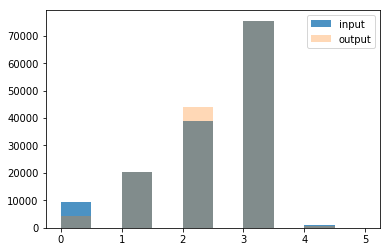

In [64]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

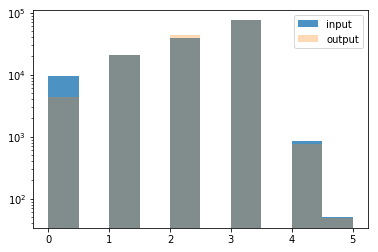

In [65]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

### Normalization (Center and Scale)

#### Group Center

In [66]:
gp_input_center = np.array([np.median(np.nan_to_num(X_input_log[input_gp == gp])) for gp in gp_list])
gp_output_center = np.array([np.median(np.nan_to_num(X_output_log[output_gp == gp])) for gp in gp_list])

In [68]:
gp_input_center, gp_output_center

(array([ 0.        ,  0.69897002,  1.50514996,  2.75663614,  4.15594292,
         5.36876822], dtype=float32),
 array([ 0.        ,  0.69897002,  1.51851392,  2.69983768,  4.15887499,
         5.4449749 ], dtype=float32))

In [69]:
gp_center = np.mean([gp_input_center, gp_output_center],axis=0)

In [70]:
gp_center

array([ 0.        ,  0.69897002,  1.511832  ,  2.72823691,  4.15740871,
        5.4068718 ], dtype=float32)

In [83]:
input_center = gp_center[input_gp].reshape(-1,1)
output_center = gp_center[output_gp].reshape(-1,1)

In [88]:
X_input_center = input_center
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

#### Group Scale

In [71]:
gp_input_scale = np.array([np.std(np.nan_to_num(X_input_log[input_gp == gp])) for gp in gp_list])
gp_output_scale = np.array([np.std(np.nan_to_num(X_output_log[output_gp == gp])) for gp in gp_list])

In [72]:
gp_input_scale, gp_output_scale

(array([ 0.40142906,  0.35661408,  0.41156927,  0.51701558,  0.33534768,
         0.56172019], dtype=float32),
 array([ 0.17716302,  0.32856828,  0.37546349,  0.48505163,  0.29477781,
         0.52268058], dtype=float32))

In [73]:
gp_scale = np.mean([gp_input_scale, gp_output_scale], axis=0)

In [74]:
gp_scale

array([ 0.28929603,  0.34259117,  0.39351636,  0.5010336 ,  0.31506276,
        0.54220039], dtype=float32)

In [85]:
input_scale = gp_scale[input_gp].reshape(-1,1)
output_scale = gp_scale[output_gp].reshape(-1,1)

In [142]:
output_scale

array([[ 0.39351636],
       [ 0.39351636],
       [ 0.34259117],
       ..., 
       [ 0.39351636],
       [ 0.34259117],
       [ 0.39351636]], dtype=float32)

In [143]:
output_gp

array([2, 2, 1, ..., 2, 1, 2])

In [146]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

#### Use Regular Median as the Center for X

#Not including nan
#X_input_center = np.nan_to_num(np.nanmedian(X_input_log, axis=-1)).reshape(-1,1)
#X_output_center = np.nan_to_num(np.nanmedian(X_output_log, axis=-1)).reshape(-1,1)

#Another choice: Including nan
#X_input_center = np.median(np.nan_to_num(X_input_log), axis=-1).reshape(-1,1)
#X_output_center = np.median(np.nan_to_num(X_output_log), axis=-1).reshape(-1,1)

#### Use Fib Median as the Center for Y

Y_input_center = log(fib_input_median).reshape(-1,1)
Y_output_center = log(fib_output_median).reshape(-1,1)
#Y_input_center = Y_output_center  # using Y_output_center instead

Y_input_center, Y_output_center

plt.scatter(X_input_center.reshape(-1),Y_input_center.reshape(-1))
plt.show()

Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

Z_input_center.shape

#### Choice of default scale

input_log = log(input_data)  # log of input_data with nan
output_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

default_input_scale = np.nanmedian(np.nanstd(X_input_log, axis=-1))
default_input_scale

default_output_scale = np.nanmedian(np.nanstd(X_output_log, axis=-1))
default_output_scale

default_scale = np.mean([default_input_scale, default_output_scale]); default_scale

#### Compute Median and Stdev

Here we are not using this median as center

Y_input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_input_center  # remember sample-wised center

input_scale = np.nan_to_num(np.nanstd(X_input_log, axis=-1)).reshape(-1,1)
input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

Y_output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_output_center  # remember sample-wised center

output_scale = np.nan_to_num(np.nanstd(X_output_log, axis=-1)).reshape(-1,1)
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
output_scale  # remember sample-wised scale

Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [86]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [89]:
# Normalize after nan->0
X_input = transform(np.nan_to_num(X_input_log), X_input_center, input_scale)
X_output = transform(np.nan_to_num(X_output_log), X_output_center, output_scale)
Y_input = transform(np.nan_to_num(Y_input_log), Y_input_center, input_scale)
if test_length:
    Y_output = transform(np.nan_to_num(Y_output_log), Y_output_center, output_scale)

# Another choice: Normalize before nan->0
#X_input = np.nan_to_num(transform(X_input_log, X_input_center, input_scale))
#X_output = np.nan_to_num(transform(X_output_log, X_output_center, output_scale))
#Y_input = np.nan_to_num(transform(Y_input_log, Y_input_center, input_scale))
#if test_length:
#    Y_output = np.nan_to_num(transform(Y_output_log, Y_output_center, output_scale))

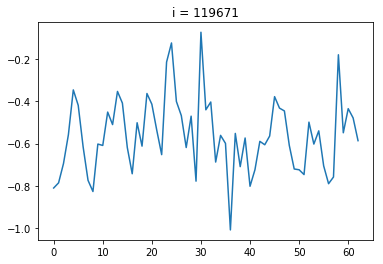

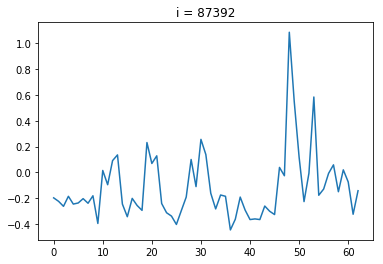

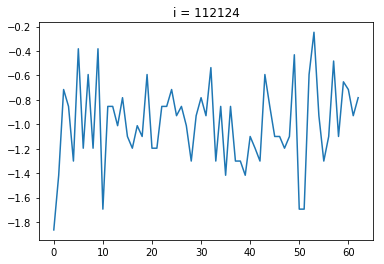

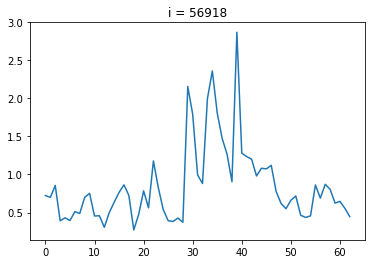

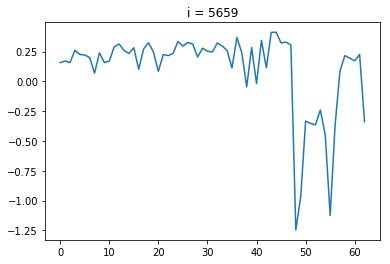

array([119671,  87392, 112124,  56918,   5659])

In [90]:
examine(Y_input)

If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.

If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

input_data_norm = transform(input_data_log, Y_input_center, input_scale)
output_data_norm = transform(output_data_log, Y_output_center, output_scale)

Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [91]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(X_input)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, Y_input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, Y_output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(Y_input_center, bins=40, alpha=0.5, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.5, label='output')
plt.hist(X_input_center, bins=40, alpha=0.5, label='input')
plt.hist(X_output_center, bins=40, alpha=0.5, label='output')
#plt.hist(Z_input_center, bins=40, alpha=0.5, label='Z_input')
plt.legend()
plt.show()

plt.hist(Y_input_center, bins=40, alpha=0.7, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
#plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

#### Make (X,Y) pairs data from data set

X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

Z_output = Y_input

Z_input.shape, Z_output.shape

#### Original data

In [92]:
X_input_ori = np.nan_to_num(X_input_raw)
Y_input_ori = np.nan_to_num(Y_input_raw)
X_output_ori = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_ori = np.nan_to_num(Y_output_raw)

X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

In [93]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -13.1955 20.2846 0.0 1.06775
(145063, 63) -13.1955 20.1457 0.0 1.45315
(145063, 63) -8.55389 18.9108 0.0 0.954945
(145063, 63) -13.1955 15.4754 -0.0601484 1.04979
(145063, 63) 0.0 2.32094e+07 126.0 63765.9
(145063, 63) 0.0 6.72643e+07 128.0 155484.0
(145063, 63) 0.0 2.46307e+07 123.0 65785.6
(145063, 63) 0.0 1.86702e+07 113.0 57469.1


arr_info((Z_input,))

#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [94]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
Y_input_center_list = [Y_input_center[input_gp == gp] for gp in gp_list]
Y_output_center_list = [Y_output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1); A_input.shape, A_output.shape

In [96]:
A_input = np.concatenate((input_median.reshape(-1,1), input_stdev.reshape(-1,1)), axis=1)
A_output = np.concatenate((output_median.reshape(-1,1), output_stdev.reshape(-1,1)), axis=1)
A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [97]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [98]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [99]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [100]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [101]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [102]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(89.811005, 109.89138, 0.0)

In [103]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.41732, 58.828331)

In [104]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386 84.4141


In [105]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.325
40.4041


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [106]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [107]:
n_ens = 5
ens_list = list(range(n_ens))

In [114]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_x = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        
        #layer_z = Input(shape=(y_length,), name='z_input')
        #layer_t = Reshape((-1, 1))(layer_0)
        #layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
        #layer_t = AveragePooling1D(pool_size=2)(layer_t)
        #layer_cnn_z = Flatten()(layer_t)
                
        #layer_t = concatenate([layer_cnn_x, layer_a, layer_cnn_z])
        layer_t = concatenate([layer_cnn_x, layer_a])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        #model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
        model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 1: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 2: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 3: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 4: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 


In [115]:
models_ens[0][1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_32 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_32 (Conv1D)               (None, 61, 120)       480         reshape_32[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_32 (AveragePoo (None, 30, 120)       0           conv1d_32[0][0]                  
___________________________________________________________________________________________

In [110]:
np.array(models_ens).shape

(5, 6)

In [111]:
len(gp_list)

6

In [116]:
epochs_list = [40,40,40,40,60,80]  # change to smaller epochs later (1,1,20,40,60,80)

In [117]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 1 / 5 ===
--- Group: 1 / 6 ---
Train on 8510 samples, validate on 946 samples
Epoch 1/40
6s - loss: 1.3669 - k_smape: 189.2245 - val_loss: 1.0495 - val_k_smape: 181.9708
Epoch 2/40
1s - loss: 1.2032 - k_smape: 184.5691 - val_loss: 1.0719 - val_k_smape: 182.7536
Epoch 3/40
1s - loss: 1.1832 - k_smape: 184.1579 - val_loss: 1.0380 - val_k_smape: 182.1556
Epoch 4/40
1s - loss: 1.1741 - k_smape: 183.9560 - val_loss: 1.0429 - val_k_smape: 181.9717
Epoch 5/40
1s - loss: 1.1640 - k_smape: 183.8505 - val_loss: 1.0377 - val_k_smape: 181.7952
Epoch 6/40
1s - loss: 1.1552 - k_smape: 183.6084 - val_loss: 1.0243 - val_k_smape: 181.1732
Epoch 7/40
1s - loss: 1.1400 - k_smape: 183.2478 - val_loss: 1.0261 - val_k_smape: 181.0539
Epoch 8/40
1s - loss: 1.1385 - k_smape: 183.1355 - val_loss: 1.0481 - val_k_smape: 181.1988
Epoch 9/40
1s - loss: 1.1463 - k_smape: 183.5059 - val_loss: 1.0223 - val_k_smape: 181.3871
Epoch 10/40
1s - loss: 1.1420 - k_smape: 183.1583 - val_loss: 1.0211 - val_k_smape: 1

8s - loss: 0.5756 - k_smape: 79.4511 - val_loss: 0.5780 - val_k_smape: 83.5910
Epoch 8/40
8s - loss: 0.5728 - k_smape: 79.1660 - val_loss: 0.5795 - val_k_smape: 83.7886
Epoch 9/40
8s - loss: 0.5709 - k_smape: 78.9119 - val_loss: 0.5778 - val_k_smape: 82.5017
Epoch 10/40
8s - loss: 0.5699 - k_smape: 78.9130 - val_loss: 0.5766 - val_k_smape: 83.6576
Epoch 11/40
8s - loss: 0.5675 - k_smape: 78.5791 - val_loss: 0.5815 - val_k_smape: 85.6442
Epoch 12/40
8s - loss: 0.5669 - k_smape: 78.4670 - val_loss: 0.5784 - val_k_smape: 84.9388
Epoch 13/40
7s - loss: 0.5661 - k_smape: 78.4786 - val_loss: 0.5770 - val_k_smape: 83.8842
Epoch 14/40
7s - loss: 0.5653 - k_smape: 78.3927 - val_loss: 0.5810 - val_k_smape: 85.6340
Epoch 15/40
8s - loss: 0.5632 - k_smape: 78.1644 - val_loss: 0.5774 - val_k_smape: 84.7211
Epoch 16/40
8s - loss: 0.5633 - k_smape: 78.1175 - val_loss: 0.5760 - val_k_smape: 85.1010
Epoch 17/40
8s - loss: 0.5620 - k_smape: 78.1158 - val_loss: 0.5776 - val_k_smape: 85.1158
Epoch 18/40
8

0s - loss: 0.5316 - k_smape: 84.4842 - val_loss: 0.6948 - val_k_smape: 82.7972
Epoch 18/60
0s - loss: 0.5222 - k_smape: 84.2854 - val_loss: 0.7010 - val_k_smape: 82.7459
Epoch 19/60
0s - loss: 0.5158 - k_smape: 83.4861 - val_loss: 0.6895 - val_k_smape: 82.9495
Epoch 20/60
0s - loss: 0.5082 - k_smape: 81.9356 - val_loss: 0.6696 - val_k_smape: 80.8226
Epoch 21/60
0s - loss: 0.5162 - k_smape: 84.6109 - val_loss: 0.7198 - val_k_smape: 86.1861
Epoch 22/60
0s - loss: 0.4977 - k_smape: 81.3867 - val_loss: 0.6342 - val_k_smape: 77.6900
Epoch 23/60
0s - loss: 0.4967 - k_smape: 80.1146 - val_loss: 0.7108 - val_k_smape: 83.8608
Epoch 24/60
0s - loss: 0.4966 - k_smape: 80.8236 - val_loss: 0.6534 - val_k_smape: 77.9942
Epoch 25/60
0s - loss: 0.4972 - k_smape: 80.4672 - val_loss: 0.6502 - val_k_smape: 79.3297
Epoch 26/60
0s - loss: 0.4845 - k_smape: 78.9469 - val_loss: 0.6566 - val_k_smape: 78.1356
Epoch 27/60
0s - loss: 0.4779 - k_smape: 79.2095 - val_loss: 0.6515 - val_k_smape: 78.2463
Epoch 28/60

0s - loss: 0.4201 - k_smape: 54.0923 - val_loss: 0.1423 - val_k_smape: 51.4030
Epoch 51/80
0s - loss: 0.4392 - k_smape: 58.7447 - val_loss: 0.1696 - val_k_smape: 54.4703
Epoch 52/80
0s - loss: 0.4518 - k_smape: 58.3422 - val_loss: 0.1761 - val_k_smape: 54.9189
Epoch 53/80
0s - loss: 0.4354 - k_smape: 57.0005 - val_loss: 0.1652 - val_k_smape: 53.2438
Epoch 54/80
0s - loss: 0.4202 - k_smape: 58.4522 - val_loss: 0.1463 - val_k_smape: 50.3214
Epoch 55/80
0s - loss: 0.4192 - k_smape: 55.1346 - val_loss: 0.1181 - val_k_smape: 46.6517
Epoch 56/80
0s - loss: 0.4128 - k_smape: 53.3530 - val_loss: 0.1018 - val_k_smape: 44.3504
Epoch 57/80
0s - loss: 0.4263 - k_smape: 52.8273 - val_loss: 0.0993 - val_k_smape: 44.4191
Epoch 58/80
0s - loss: 0.4131 - k_smape: 53.1461 - val_loss: 0.1070 - val_k_smape: 45.8179
Epoch 59/80
0s - loss: 0.3992 - k_smape: 52.0802 - val_loss: 0.1139 - val_k_smape: 47.0660
Epoch 60/80
0s - loss: 0.4057 - k_smape: 53.2084 - val_loss: 0.1140 - val_k_smape: 47.8284
Epoch 61/80

4s - loss: 0.6496 - k_smape: 104.6687 - val_loss: 0.7567 - val_k_smape: 117.1770
Epoch 19/40
4s - loss: 0.6490 - k_smape: 104.8774 - val_loss: 0.7560 - val_k_smape: 115.4858
Epoch 20/40
4s - loss: 0.6481 - k_smape: 104.6853 - val_loss: 0.7574 - val_k_smape: 116.9873
Epoch 21/40
4s - loss: 0.6479 - k_smape: 104.7030 - val_loss: 0.7578 - val_k_smape: 114.5187
Epoch 22/40
4s - loss: 0.6460 - k_smape: 104.5047 - val_loss: 0.7556 - val_k_smape: 116.0906
Epoch 23/40
4s - loss: 0.6468 - k_smape: 104.6065 - val_loss: 0.7569 - val_k_smape: 116.3095
Epoch 24/40
4s - loss: 0.6457 - k_smape: 104.4372 - val_loss: 0.7586 - val_k_smape: 116.3793
Epoch 25/40
4s - loss: 0.6457 - k_smape: 104.4084 - val_loss: 0.7580 - val_k_smape: 116.5344
Epoch 26/40
4s - loss: 0.6431 - k_smape: 104.3052 - val_loss: 0.7595 - val_k_smape: 116.0251
Epoch 27/40
4s - loss: 0.6436 - k_smape: 104.4099 - val_loss: 0.7614 - val_k_smape: 115.8150
Epoch 28/40
4s - loss: 0.6437 - k_smape: 104.2927 - val_loss: 0.7596 - val_k_smape

15s - loss: 0.3465 - k_smape: 61.6883 - val_loss: 0.3554 - val_k_smape: 64.2645
Epoch 27/40
15s - loss: 0.3464 - k_smape: 61.8692 - val_loss: 0.3515 - val_k_smape: 62.3122
Epoch 28/40
15s - loss: 0.3464 - k_smape: 61.7953 - val_loss: 0.3485 - val_k_smape: 62.1416
Epoch 29/40
15s - loss: 0.3456 - k_smape: 61.6762 - val_loss: 0.3479 - val_k_smape: 62.0025
Epoch 30/40
15s - loss: 0.3454 - k_smape: 61.6792 - val_loss: 0.3529 - val_k_smape: 63.1768
Epoch 31/40
15s - loss: 0.3455 - k_smape: 61.7223 - val_loss: 0.3482 - val_k_smape: 61.8785
Epoch 32/40
15s - loss: 0.3441 - k_smape: 61.5523 - val_loss: 0.3491 - val_k_smape: 62.3996
Epoch 33/40
15s - loss: 0.3449 - k_smape: 61.7434 - val_loss: 0.3516 - val_k_smape: 61.7271
Epoch 34/40
15s - loss: 0.3437 - k_smape: 61.4633 - val_loss: 0.3520 - val_k_smape: 62.5750
Epoch 35/40
15s - loss: 0.3440 - k_smape: 61.4006 - val_loss: 0.3506 - val_k_smape: 62.5293
Epoch 36/40
15s - loss: 0.3422 - k_smape: 61.2805 - val_loss: 0.3483 - val_k_smape: 62.0983


Epoch 24/80
0s - loss: 0.5980 - k_smape: 81.5573 - val_loss: 0.2923 - val_k_smape: 73.1992
Epoch 25/80
0s - loss: 0.5855 - k_smape: 84.3937 - val_loss: 0.2826 - val_k_smape: 72.2214
Epoch 26/80
0s - loss: 0.5737 - k_smape: 79.8135 - val_loss: 0.2793 - val_k_smape: 72.1358
Epoch 27/80
0s - loss: 0.5572 - k_smape: 79.2651 - val_loss: 0.2845 - val_k_smape: 73.2439
Epoch 28/80
0s - loss: 0.5620 - k_smape: 80.7381 - val_loss: 0.2844 - val_k_smape: 73.6640
Epoch 29/80
0s - loss: 0.5468 - k_smape: 77.0788 - val_loss: 0.2836 - val_k_smape: 73.9752
Epoch 30/80
0s - loss: 0.5564 - k_smape: 80.5131 - val_loss: 0.2743 - val_k_smape: 73.0251
Epoch 31/80
0s - loss: 0.5715 - k_smape: 79.4015 - val_loss: 0.2591 - val_k_smape: 71.1784
Epoch 32/80
0s - loss: 0.5606 - k_smape: 79.5351 - val_loss: 0.2414 - val_k_smape: 68.4970
Epoch 33/80
0s - loss: 0.5390 - k_smape: 74.4484 - val_loss: 0.2218 - val_k_smape: 65.2380
Epoch 34/80
0s - loss: 0.5513 - k_smape: 73.3717 - val_loss: 0.2081 - val_k_smape: 62.7521

1s - loss: 1.1084 - k_smape: 182.4199 - val_loss: 1.0114 - val_k_smape: 180.3970
Epoch 34/40
1s - loss: 1.1033 - k_smape: 182.2817 - val_loss: 1.0094 - val_k_smape: 180.2165
Epoch 35/40
1s - loss: 1.1061 - k_smape: 182.3730 - val_loss: 1.0196 - val_k_smape: 180.2525
Epoch 36/40
1s - loss: 1.1014 - k_smape: 182.2045 - val_loss: 1.0061 - val_k_smape: 180.3526
Epoch 37/40
1s - loss: 1.0955 - k_smape: 182.1246 - val_loss: 1.0063 - val_k_smape: 180.0531
Epoch 38/40
1s - loss: 1.0948 - k_smape: 182.1402 - val_loss: 1.0079 - val_k_smape: 180.0485
Epoch 39/40
1s - loss: 1.0965 - k_smape: 182.0917 - val_loss: 1.0085 - val_k_smape: 180.0097
Epoch 40/40
1s - loss: 1.1053 - k_smape: 182.2144 - val_loss: 1.0358 - val_k_smape: 180.7023
--- Group: 2 / 6 ---
Train on 18463 samples, validate on 2052 samples
Epoch 1/40
5s - loss: 0.7316 - k_smape: 123.7702 - val_loss: 0.7545 - val_k_smape: 118.0018
Epoch 2/40
4s - loss: 0.6873 - k_smape: 111.1999 - val_loss: 0.7539 - val_k_smape: 119.3623
Epoch 3/40
4s 

Train on 67774 samples, validate on 7531 samples
Epoch 1/40
16s - loss: 0.4300 - k_smape: 74.4467 - val_loss: 0.3780 - val_k_smape: 67.3887
Epoch 2/40
15s - loss: 0.3776 - k_smape: 65.9143 - val_loss: 0.3643 - val_k_smape: 63.6474
Epoch 3/40
15s - loss: 0.3700 - k_smape: 64.8730 - val_loss: 0.3603 - val_k_smape: 62.7257
Epoch 4/40
15s - loss: 0.3658 - k_smape: 64.3479 - val_loss: 0.3664 - val_k_smape: 64.5962
Epoch 5/40
15s - loss: 0.3628 - k_smape: 64.0427 - val_loss: 0.3563 - val_k_smape: 62.8892
Epoch 6/40
15s - loss: 0.3615 - k_smape: 63.8361 - val_loss: 0.3585 - val_k_smape: 62.7694
Epoch 7/40
15s - loss: 0.3604 - k_smape: 63.6359 - val_loss: 0.3562 - val_k_smape: 62.9814
Epoch 8/40
15s - loss: 0.3596 - k_smape: 63.4728 - val_loss: 0.3565 - val_k_smape: 62.6616
Epoch 9/40
15s - loss: 0.3585 - k_smape: 63.3969 - val_loss: 0.3584 - val_k_smape: 63.6222
Epoch 10/40
15s - loss: 0.3566 - k_smape: 63.2422 - val_loss: 0.3605 - val_k_smape: 63.6116
Epoch 11/40
15s - loss: 0.3559 - k_smape

0s - loss: 0.4074 - k_smape: 70.4956 - val_loss: 0.6025 - val_k_smape: 75.5959
Epoch 52/60
0s - loss: 0.4107 - k_smape: 70.9109 - val_loss: 0.6000 - val_k_smape: 74.7296
Epoch 53/60
0s - loss: 0.4062 - k_smape: 69.2696 - val_loss: 0.5996 - val_k_smape: 71.9127
Epoch 54/60
0s - loss: 0.4122 - k_smape: 70.3680 - val_loss: 0.6391 - val_k_smape: 77.6753
Epoch 55/60
0s - loss: 0.4156 - k_smape: 70.3909 - val_loss: 0.6305 - val_k_smape: 73.7046
Epoch 56/60
0s - loss: 0.3993 - k_smape: 68.8854 - val_loss: 0.6231 - val_k_smape: 75.4205
Epoch 57/60
0s - loss: 0.4041 - k_smape: 69.3903 - val_loss: 0.6409 - val_k_smape: 78.3621
Epoch 58/60
0s - loss: 0.4080 - k_smape: 70.8218 - val_loss: 0.6171 - val_k_smape: 72.8875
Epoch 59/60
0s - loss: 0.3988 - k_smape: 69.4932 - val_loss: 0.6108 - val_k_smape: 74.0779
Epoch 60/60
0s - loss: 0.3921 - k_smape: 69.3889 - val_loss: 0.6121 - val_k_smape: 73.7474
--- Group: 6 / 6 ---
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 1.0024 - k_smape

Train on 8510 samples, validate on 946 samples
Epoch 1/40
2s - loss: 1.3552 - k_smape: 188.7096 - val_loss: 1.0325 - val_k_smape: 181.3685
Epoch 2/40
1s - loss: 1.2040 - k_smape: 184.5027 - val_loss: 1.0574 - val_k_smape: 182.3740
Epoch 3/40
1s - loss: 1.1743 - k_smape: 183.9418 - val_loss: 1.0551 - val_k_smape: 182.0867
Epoch 4/40
1s - loss: 1.1643 - k_smape: 183.7837 - val_loss: 1.0252 - val_k_smape: 181.1486
Epoch 5/40
1s - loss: 1.1581 - k_smape: 183.5975 - val_loss: 1.0296 - val_k_smape: 180.9367
Epoch 6/40
1s - loss: 1.1568 - k_smape: 183.5731 - val_loss: 1.0479 - val_k_smape: 181.8896
Epoch 7/40
1s - loss: 1.1539 - k_smape: 183.4459 - val_loss: 1.0231 - val_k_smape: 181.1319
Epoch 8/40
1s - loss: 1.1416 - k_smape: 183.1908 - val_loss: 1.0220 - val_k_smape: 181.2921
Epoch 9/40
1s - loss: 1.1412 - k_smape: 183.2019 - val_loss: 1.0310 - val_k_smape: 181.2640
Epoch 10/40
1s - loss: 1.1356 - k_smape: 183.0760 - val_loss: 1.0182 - val_k_smape: 180.7006
Epoch 11/40
1s - loss: 1.1293 - 

7s - loss: 0.5707 - k_smape: 79.0543 - val_loss: 0.5776 - val_k_smape: 84.1139
Epoch 9/40
7s - loss: 0.5701 - k_smape: 79.0075 - val_loss: 0.5781 - val_k_smape: 84.0602
Epoch 10/40
7s - loss: 0.5689 - k_smape: 78.8509 - val_loss: 0.5770 - val_k_smape: 84.9348
Epoch 11/40
7s - loss: 0.5672 - k_smape: 78.6637 - val_loss: 0.5793 - val_k_smape: 85.4864
Epoch 12/40
7s - loss: 0.5663 - k_smape: 78.5247 - val_loss: 0.5784 - val_k_smape: 84.6246
Epoch 13/40
7s - loss: 0.5655 - k_smape: 78.4759 - val_loss: 0.5764 - val_k_smape: 84.2654
Epoch 14/40
7s - loss: 0.5634 - k_smape: 78.2156 - val_loss: 0.5771 - val_k_smape: 84.6537
Epoch 15/40
7s - loss: 0.5624 - k_smape: 78.1202 - val_loss: 0.5776 - val_k_smape: 85.3426
Epoch 16/40
7s - loss: 0.5606 - k_smape: 78.0446 - val_loss: 0.5752 - val_k_smape: 84.4702
Epoch 17/40
7s - loss: 0.5602 - k_smape: 77.9139 - val_loss: 0.5771 - val_k_smape: 84.8942
Epoch 18/40
7s - loss: 0.5592 - k_smape: 77.8533 - val_loss: 0.5772 - val_k_smape: 85.3567
Epoch 19/40


0s - loss: 0.5146 - k_smape: 84.1821 - val_loss: 0.7190 - val_k_smape: 86.6098
Epoch 18/60
0s - loss: 0.5090 - k_smape: 83.7989 - val_loss: 0.6627 - val_k_smape: 78.8505
Epoch 19/60
0s - loss: 0.4996 - k_smape: 81.8061 - val_loss: 0.6923 - val_k_smape: 83.7667
Epoch 20/60
0s - loss: 0.4928 - k_smape: 82.4171 - val_loss: 0.6941 - val_k_smape: 82.2415
Epoch 21/60
0s - loss: 0.4988 - k_smape: 82.4949 - val_loss: 0.6632 - val_k_smape: 79.4552
Epoch 22/60
0s - loss: 0.4828 - k_smape: 79.1730 - val_loss: 0.6638 - val_k_smape: 80.2385
Epoch 23/60
0s - loss: 0.4854 - k_smape: 80.7007 - val_loss: 0.6504 - val_k_smape: 77.4103
Epoch 24/60
0s - loss: 0.4860 - k_smape: 79.6494 - val_loss: 0.6659 - val_k_smape: 78.3440
Epoch 25/60
0s - loss: 0.4768 - k_smape: 77.9553 - val_loss: 0.6458 - val_k_smape: 76.9338
Epoch 26/60
0s - loss: 0.4670 - k_smape: 76.6145 - val_loss: 0.6467 - val_k_smape: 78.2737
Epoch 27/60
0s - loss: 0.4655 - k_smape: 77.8924 - val_loss: 0.6296 - val_k_smape: 75.8398
Epoch 28/60

0s - loss: 0.4533 - k_smape: 60.9582 - val_loss: 0.1844 - val_k_smape: 58.0365
Epoch 49/80
0s - loss: 0.4579 - k_smape: 61.3079 - val_loss: 0.1566 - val_k_smape: 54.1454
Epoch 50/80
0s - loss: 0.4492 - k_smape: 56.3446 - val_loss: 0.1433 - val_k_smape: 51.9131
Epoch 51/80
0s - loss: 0.4294 - k_smape: 55.9462 - val_loss: 0.1421 - val_k_smape: 51.1649
Epoch 52/80
0s - loss: 0.4340 - k_smape: 57.1933 - val_loss: 0.1470 - val_k_smape: 50.9790
Epoch 53/80
0s - loss: 0.4511 - k_smape: 58.6066 - val_loss: 0.1425 - val_k_smape: 50.1281
Epoch 54/80
0s - loss: 0.4530 - k_smape: 58.4842 - val_loss: 0.1292 - val_k_smape: 48.7571
Epoch 55/80
0s - loss: 0.4371 - k_smape: 53.4416 - val_loss: 0.1373 - val_k_smape: 50.4886
Epoch 56/80
0s - loss: 0.4273 - k_smape: 53.8606 - val_loss: 0.1891 - val_k_smape: 56.2544
Epoch 57/80
0s - loss: 0.4528 - k_smape: 61.3299 - val_loss: 0.2102 - val_k_smape: 58.5645
Epoch 58/80
0s - loss: 0.4310 - k_smape: 56.5432 - val_loss: 0.2042 - val_k_smape: 57.5129
Epoch 59/80

4s - loss: 0.6511 - k_smape: 105.3161 - val_loss: 0.7564 - val_k_smape: 114.9652
Epoch 17/40
4s - loss: 0.6510 - k_smape: 105.0254 - val_loss: 0.7579 - val_k_smape: 116.8965
Epoch 18/40
4s - loss: 0.6504 - k_smape: 105.0028 - val_loss: 0.7608 - val_k_smape: 117.7280
Epoch 19/40
4s - loss: 0.6472 - k_smape: 104.8644 - val_loss: 0.7583 - val_k_smape: 117.1710
Epoch 20/40
4s - loss: 0.6462 - k_smape: 104.7441 - val_loss: 0.7589 - val_k_smape: 118.1200
Epoch 21/40
4s - loss: 0.6453 - k_smape: 104.7283 - val_loss: 0.7624 - val_k_smape: 119.0309
Epoch 22/40
4s - loss: 0.6446 - k_smape: 104.3202 - val_loss: 0.7584 - val_k_smape: 116.3473
Epoch 23/40
4s - loss: 0.6441 - k_smape: 104.5127 - val_loss: 0.7593 - val_k_smape: 116.9987
Epoch 24/40
4s - loss: 0.6425 - k_smape: 104.5262 - val_loss: 0.7585 - val_k_smape: 114.8784
Epoch 25/40
4s - loss: 0.6442 - k_smape: 104.2977 - val_loss: 0.7555 - val_k_smape: 116.1644
Epoch 26/40
4s - loss: 0.6412 - k_smape: 104.3826 - val_loss: 0.7604 - val_k_smape

15s - loss: 0.3487 - k_smape: 62.1141 - val_loss: 0.3577 - val_k_smape: 63.1886
Epoch 25/40
15s - loss: 0.3483 - k_smape: 62.0690 - val_loss: 0.3524 - val_k_smape: 62.6423
Epoch 26/40
15s - loss: 0.3473 - k_smape: 61.9008 - val_loss: 0.3478 - val_k_smape: 61.7906
Epoch 27/40
15s - loss: 0.3472 - k_smape: 61.8167 - val_loss: 0.3543 - val_k_smape: 62.7981
Epoch 28/40
15s - loss: 0.3467 - k_smape: 61.7758 - val_loss: 0.3564 - val_k_smape: 62.6129
Epoch 29/40
15s - loss: 0.3464 - k_smape: 61.7035 - val_loss: 0.3540 - val_k_smape: 62.9867
Epoch 30/40
15s - loss: 0.3460 - k_smape: 61.6703 - val_loss: 0.3547 - val_k_smape: 62.9730
Epoch 31/40
15s - loss: 0.3449 - k_smape: 61.6302 - val_loss: 0.3499 - val_k_smape: 62.1821
Epoch 32/40
15s - loss: 0.3456 - k_smape: 61.6024 - val_loss: 0.3499 - val_k_smape: 62.1246
Epoch 33/40
15s - loss: 0.3449 - k_smape: 61.4733 - val_loss: 0.3499 - val_k_smape: 61.8858
Epoch 34/40
15s - loss: 0.3449 - k_smape: 61.5403 - val_loss: 0.3535 - val_k_smape: 62.7877


Epoch 13/80
0s - loss: 0.7294 - k_smape: 101.9270 - val_loss: 0.4429 - val_k_smape: 96.3275
Epoch 14/80
0s - loss: 0.7098 - k_smape: 103.8469 - val_loss: 0.4242 - val_k_smape: 93.2456
Epoch 15/80
0s - loss: 0.6802 - k_smape: 99.3413 - val_loss: 0.4003 - val_k_smape: 89.6527
Epoch 16/80
0s - loss: 0.6930 - k_smape: 101.7112 - val_loss: 0.3705 - val_k_smape: 85.3599
Epoch 17/80
0s - loss: 0.6836 - k_smape: 96.7618 - val_loss: 0.3430 - val_k_smape: 81.6500
Epoch 18/80
0s - loss: 0.6502 - k_smape: 90.6827 - val_loss: 0.3237 - val_k_smape: 78.9593
Epoch 19/80
0s - loss: 0.6456 - k_smape: 91.0847 - val_loss: 0.3048 - val_k_smape: 76.1938
Epoch 20/80
0s - loss: 0.6629 - k_smape: 91.3694 - val_loss: 0.2883 - val_k_smape: 73.7195
Epoch 21/80
0s - loss: 0.6283 - k_smape: 86.8843 - val_loss: 0.2805 - val_k_smape: 72.3619
Epoch 22/80
0s - loss: 0.6482 - k_smape: 88.3626 - val_loss: 0.2752 - val_k_smape: 71.4735
Epoch 23/80
0s - loss: 0.5971 - k_smape: 84.5191 - val_loss: 0.2749 - val_k_smape: 71.4

%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

### Training History

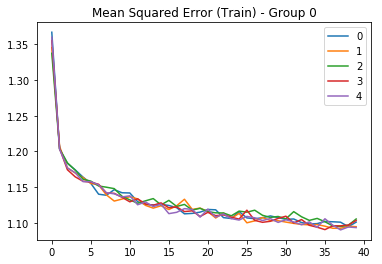

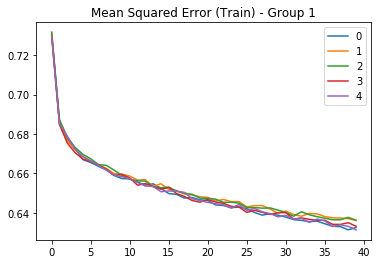

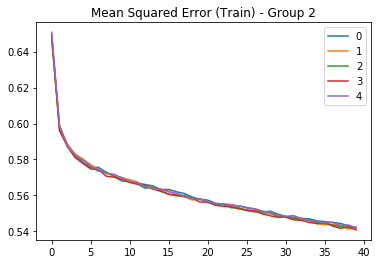

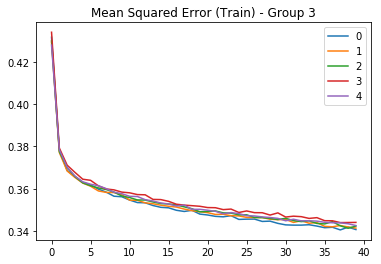

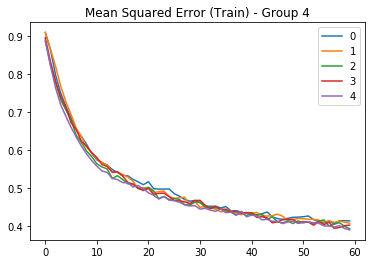

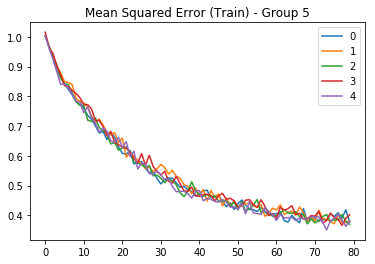

In [119]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

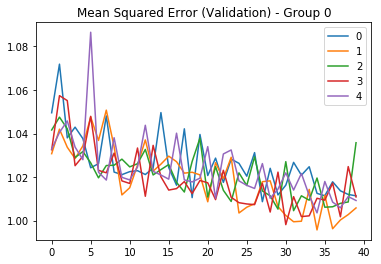

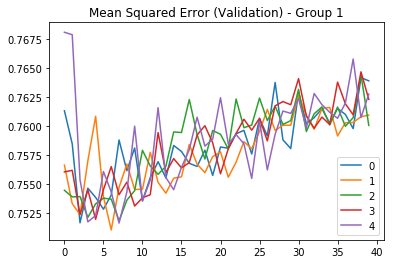

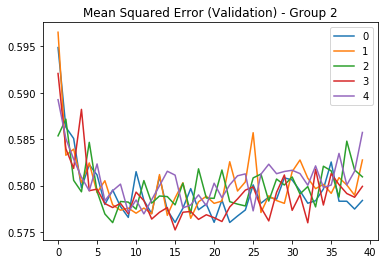

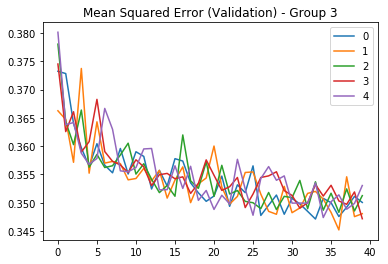

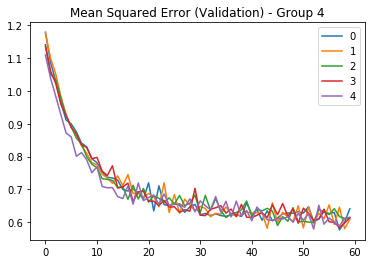

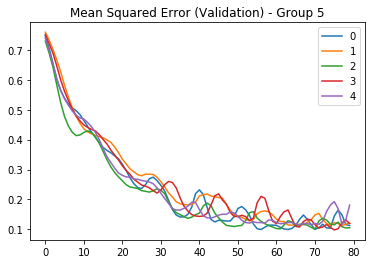

In [120]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

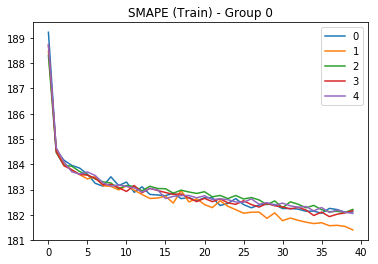

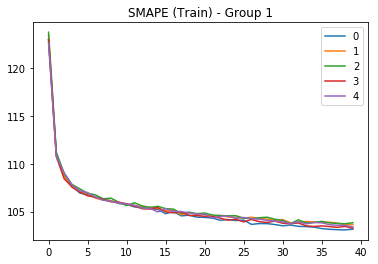

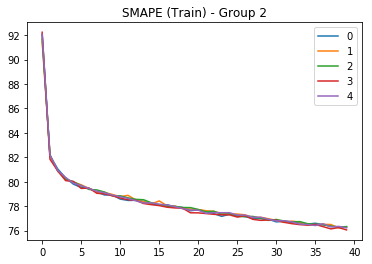

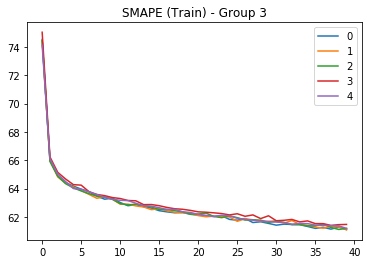

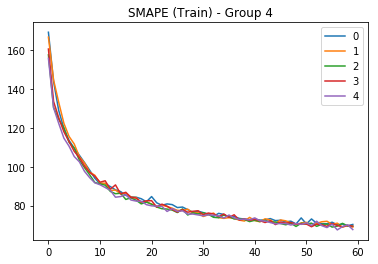

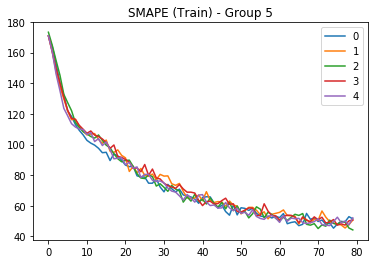

In [121]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

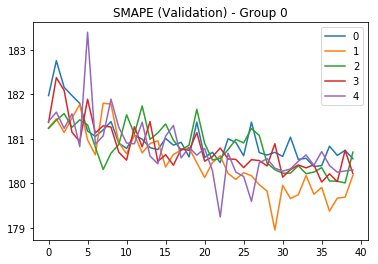

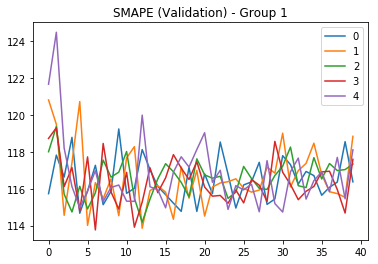

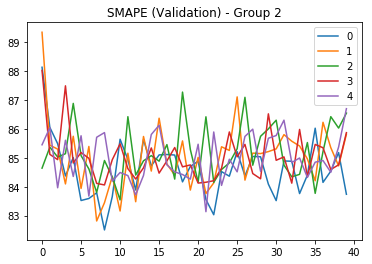

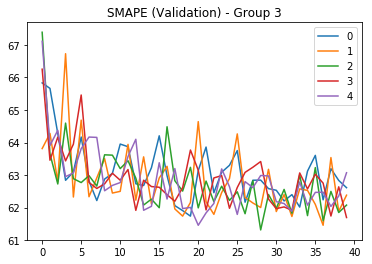

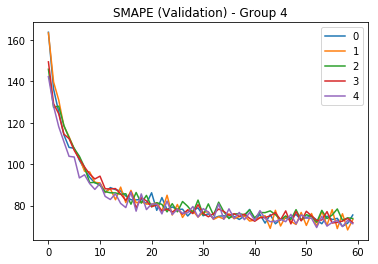

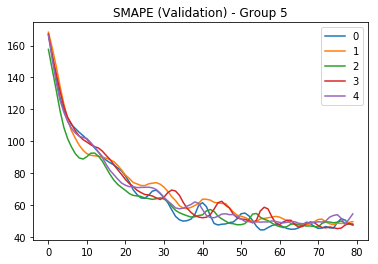

In [122]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

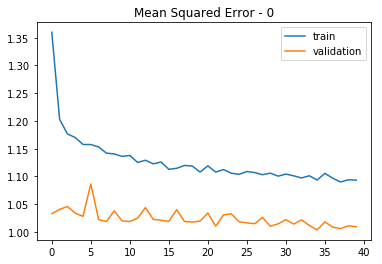

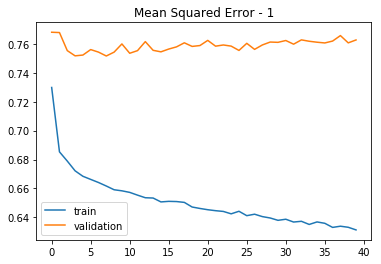

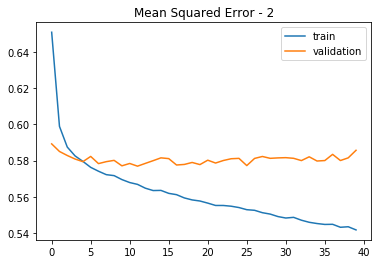

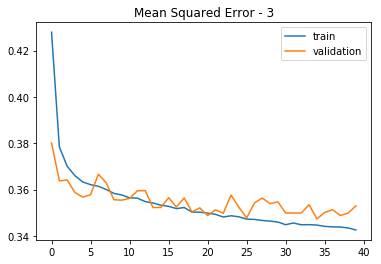

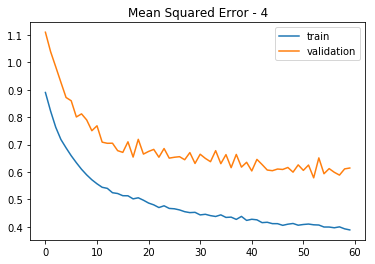

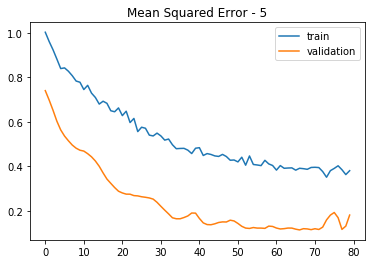

In [123]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

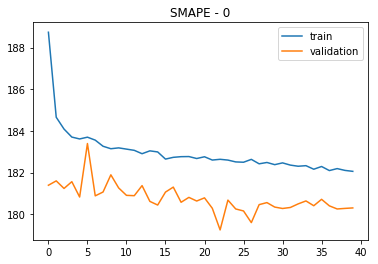

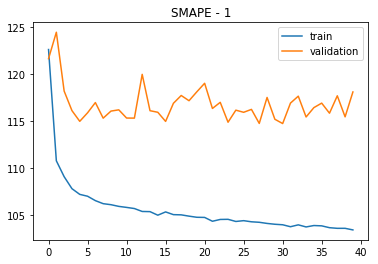

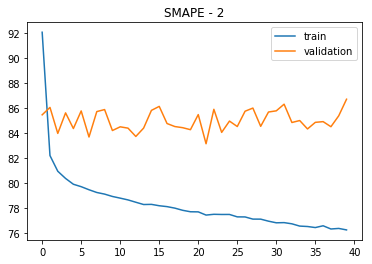

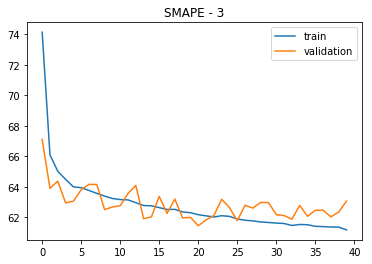

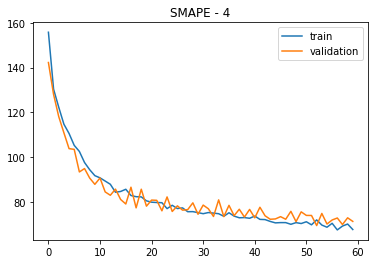

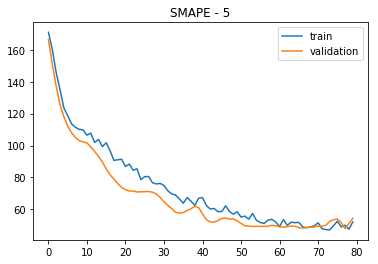

In [124]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

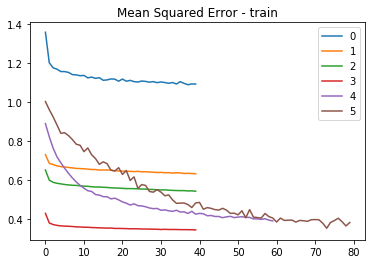

In [125]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

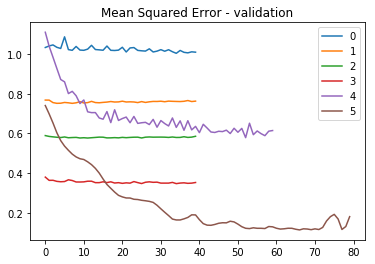

In [126]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

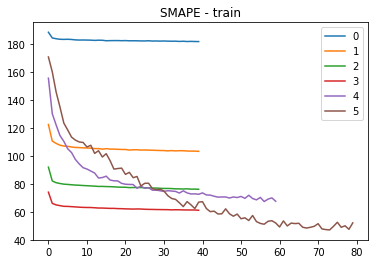

In [127]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

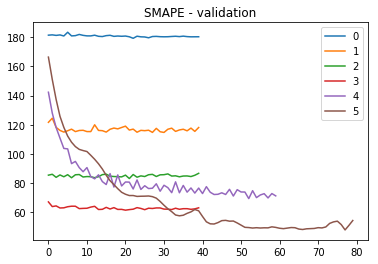

In [128]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Output Set

In [129]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 4 5 
Run 1: 0 1 2 3 4 5 
Run 2: 0 1 2 3 4 5 
Run 3: 0 1 2 3 4 5 
Run 4: 0 1 2 3 4 5 
Wall time: 1min 23s


%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Find the original index

In [130]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [131]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [132]:
for o in output_index_list:
    print(o.shape, end=' ')

(4404,) (20389,) (43974,) (75482,) (765,) (49,) 

In [133]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [134]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [152]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

#### Check predict output

In [138]:
Y_output_pred_ori_ens.shape

(5, 145063, 63)

In [144]:
Y_output_pred

array([[-0.36164382, -0.32306626, -0.28542718, ..., -0.35432738,
        -0.38348562, -0.36250311],
       [ 0.07405139,  0.059674  ,  0.10925509, ...,  0.22395189,
         0.22468428,  0.23203111],
       [-0.38089487, -0.27432454, -0.37818238, ..., -0.31625929,
        -0.33978185, -0.26159948],
       ..., 
       [ 0.29081503,  0.24691376,  0.30433181, ...,  0.44871104,
         0.41562393,  0.43279389],
       [ 0.28779614,  0.39491552,  0.31601024, ...,  0.32597566,
         0.30063087,  0.41752738],
       [-1.40746057, -1.46900296, -1.45138383, ..., -1.38599503,
        -1.37604785, -1.31180763]], dtype=float32)

In [149]:
www =unlog(untransform(Y_output_pred, Y_output_center, Y_output_scale))

In [150]:
arr_info([www])

shape, min, max, median, stdev
(145063, 63) 0.0 6.53365e+07 127.967 121283.0


Y_output_pred_ori

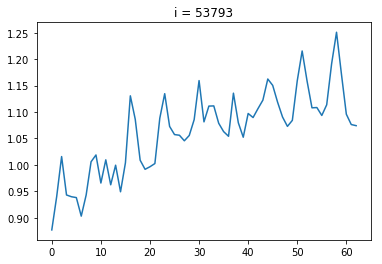

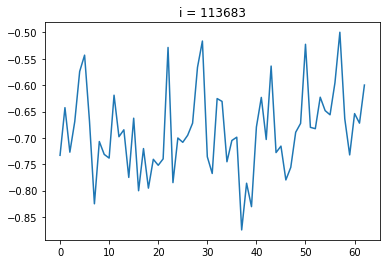

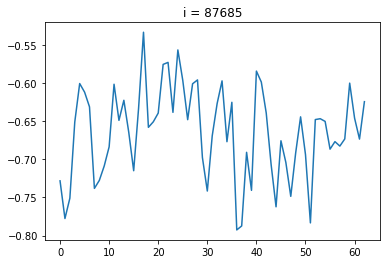

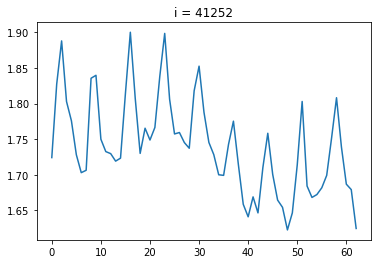

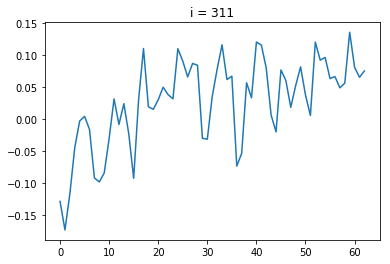

array([ 53793, 113683,  87685,  41252,    311])

In [140]:
examine(Y_output_pred)

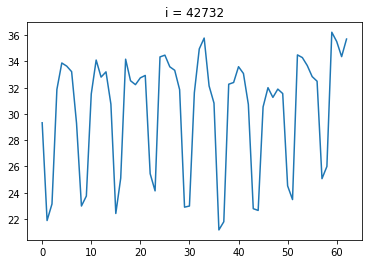

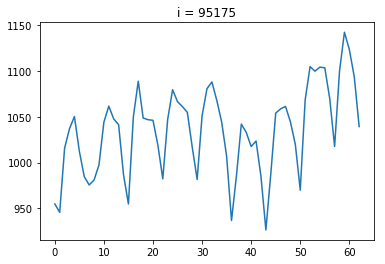

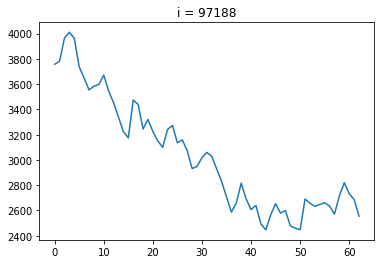

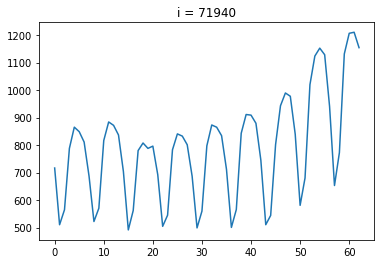

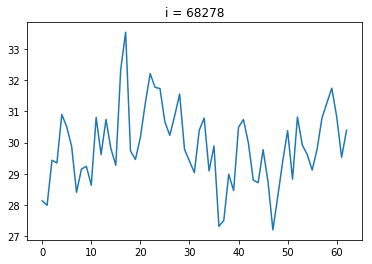

array([42732, 95175, 97188, 71940, 68278])

In [153]:
examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [154]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape, model_smape_0)
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    print('-----------')
    print(model_smape_ens_mean, model_smape_0_ens_mean)

39.8824 42.8583
39.7004 42.7196
39.7836 42.7728
39.7006 42.5072
40.4064 43.183
-----------
39.8947 42.8082


In [155]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

40.4041


### Group Scores

In [156]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [157]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [158]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [159]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [160]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [161]:
# Group scores for the model
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [162]:
gp_smape_mean = np.mean(gp_smape_ens, axis=0); gp_smape_mean

array([ 167.88613892,   62.76052094,   41.18826675,   30.15355301,
         33.13231277,   24.36665535], dtype=float32)

In [163]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [164]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

#### model_10_Modified_CNN_3_single_Std_scaler
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   4404 |  70.033 | 167.886 | 171.183 | 165.351 | 167.743 | 165.866 | 169.287 |
|  20389 |  60.668 |  62.761 |  63.006 |  62.417 |  62.871 |  62.874 |  62.634 |
|  43974 |  40.652 |  41.188 |  40.835 |  41.359 |  41.125 |  41.145 |  41.477 |
|  75482 |  34.291 |  30.154 |  30.197 |  29.832 |  29.962 |  29.843 |  30.935 |
|    765 |  36.357 |  33.132 |  32.811 |  33.964 |  32.674 |  32.198 |  34.015 |
|     49 |  20.954 |  24.367 |  24.041 |  23.319 |  22.115 |  23.183 |  29.176 |
|  Total |  40.404 |  39.895 |  39.882 |  39.700 |  39.784 |  39.701 |  40.406 |

#### model_10_Modified_CNN_3_single_Std_scaler
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   4404 |  70.033 | 167.886 | 171.183 | 165.351 | 167.743 | 165.866 | 169.287 |
|  20389 |  60.668 |  62.761 |  63.006 |  62.417 |  62.871 |  62.874 |  62.634 |
|  43974 |  40.652 |  41.188 |  40.835 |  41.359 |  41.125 |  41.145 |  41.477 |
|  75482 |  34.291 |  30.154 |  30.197 |  29.832 |  29.962 |  29.843 |  30.935 |
|    765 |  36.357 |  33.132 |  32.811 |  33.964 |  32.674 |  32.198 |  34.015 |
|     49 |  20.954 |  24.367 |  24.041 |  23.319 |  22.115 |  23.183 |  29.176 |
|  Total |  40.404 |  39.895 |  39.882 |  39.700 |  39.784 |  39.701 |  40.406 |
#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|  Total |  40.404 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Page Scores

In [165]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [166]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

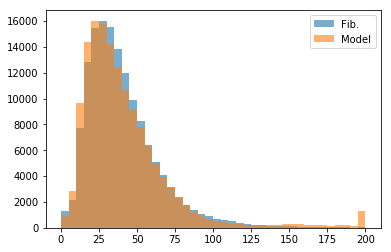

In [167]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [168]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [169]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

#### Plots

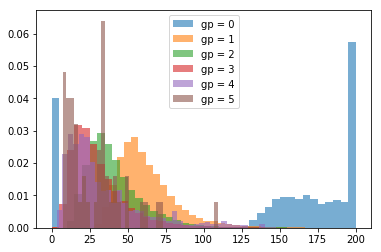

In [170]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

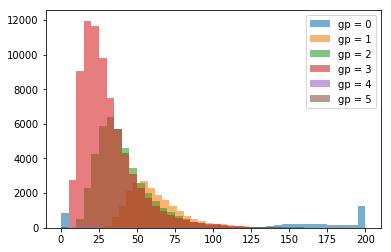

In [171]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

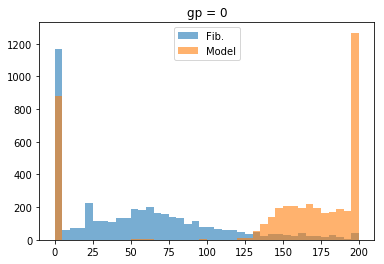

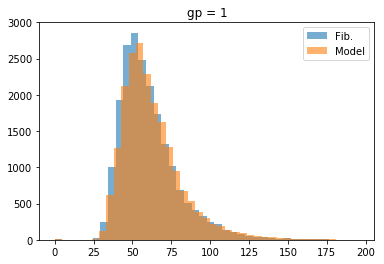

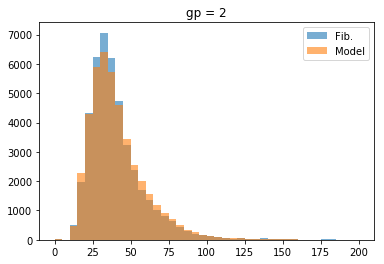

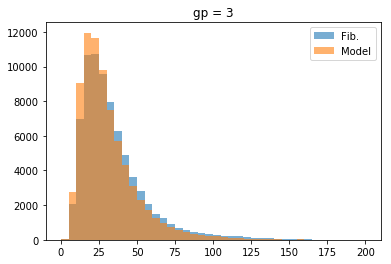

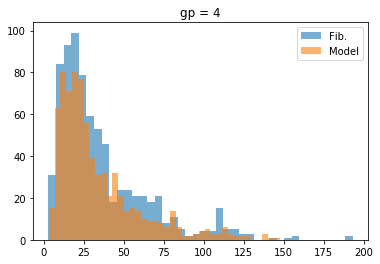

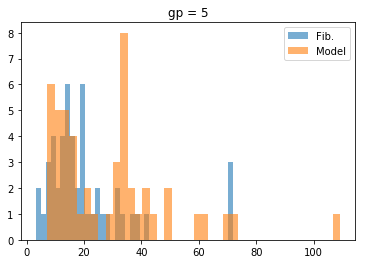

In [172]:
if test_length:
    for gp in gp_list:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
        plt.title('gp = '+str(gp)); plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [173]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [174]:
# Select group 0 from Fib.
#fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [175]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [176]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [177]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

38.266 (39.882) - model_10_Modified_CNN_3_single_Std_scaler 0
38.241 (39.700) - model_10_Modified_CNN_3_single_Std_scaler 1
38.230 (39.784) - model_10_Modified_CNN_3_single_Std_scaler 2
38.171 (39.701) - model_10_Modified_CNN_3_single_Std_scaler 3
38.866 (40.406) - model_10_Modified_CNN_3_single_Std_scaler 4
38.355 (39.895) - model_10_Modified_CNN_3_single_Std_scaler Average


## Ensemble Learning

### Ensemble Median

In [178]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [179]:
ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); ens_med_smape

39.51144

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

#Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

Y_output_pred_ori_ens_med

In [180]:
#Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med  # Our final output
#Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
#Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

## All Model Scores

In [181]:
if test_length:  # Ensemble learning model score
    #f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    #f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    #f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [182]:
if test_length: # The_score with (without) combining Fibonacci median model
    #print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    #print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    #print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

37.875 (39.511) - model_10_Modified_CNN_3_single_Std_scaler ori_ensemble_median
38.355 (39.895) - model_10_Modified_CNN_3_single_Std_scaler Average
38.266 (39.882) - model_10_Modified_CNN_3_single_Std_scaler 0
38.241 (39.700) - model_10_Modified_CNN_3_single_Std_scaler 1
38.230 (39.784) - model_10_Modified_CNN_3_single_Std_scaler 2
38.171 (39.701) - model_10_Modified_CNN_3_single_Std_scaler 3
38.866 (40.406) - model_10_Modified_CNN_3_single_Std_scaler 4


37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

#### Combined Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [183]:
# ensemble result Y_output in each group
#Y_output_pred_ori_ens_mean_list = [Y_output_pred_ori_ens_mean[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_mean_ori_list = [Y_output_pred_ens_mean_ori[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_med_ori_list = [Y_output_pred_ens_med_ori[output_gp == gp] for gp in gp_list]

In [184]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    #gp_omean_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_mean_list)]
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]
    #gp_meano_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_mean_ori_list)]


In [185]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        #print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        #print(' %7.3f ' % gp_meano_smape[gp], end='|')
        #print(' %7.3f ' % gp_medo_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_3_single_Std_scaler
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|   4404 |  70.033 | 179.535 | 167.886 | 171.183 | 165.351 | 167.743 | 165.866 | 169.287 |
|  20389 |  60.668 |  62.388 |  62.761 |  63.006 |  62.417 |  62.871 |  62.874 |  62.634 |
|  43974 |  40.652 |  40.607 |  41.188 |  40.835 |  41.359 |  41.125 |  41.145 |  41.477 |
|  75482 |  34.291 |  29.598 |  30.154 |  30.197 |  29.832 |  29.962 |  29.843 |  30.935 |
|    765 |  36.357 |  32.482 |  33.132 |  32.811 |  33.964 |  32.674 |  32.198 |  34.015 |
|     49 |  20.954 |  22.274 |  24.367 |  24.041 |  23.319 |  22.115 |  23.183 |  29.176 |
|Over All|  40.404 |  37.875 |  39.895 |  39.882 |  39.700 |  39.784 |  39.701 |  40.406 |

#### model_10_Modified_CNN_3_single_Std_scaler
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|   4404 |  70.033 | 179.535 | 167.886 | 171.183 | 165.351 | 167.743 | 165.866 | 169.287 |
|  20389 |  60.668 |  62.388 |  62.761 |  63.006 |  62.417 |  62.871 |  62.874 |  62.634 |
|  43974 |  40.652 |  40.607 |  41.188 |  40.835 |  41.359 |  41.125 |  41.145 |  41.477 |
|  75482 |  34.291 |  29.598 |  30.154 |  30.197 |  29.832 |  29.962 |  29.843 |  30.935 |
|    765 |  36.357 |  32.482 |  33.132 |  32.811 |  33.964 |  32.674 |  32.198 |  34.015 |
|     49 |  20.954 |  22.274 |  24.367 |  24.041 |  23.319 |  22.115 |  23.183 |  29.176 |
|Over All|  40.404 |  37.875 |  39.895 |  39.882 |  39.700 |  39.784 |  39.701 |  40.406 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## More Explore

### Group Models in other Groups

In [190]:
%%time
smape_gpm_gp_ens = []
for run in ens_list:
    print('Run', run)
    models = models_ens[run]
    Y_output_all_ori_list = unlog(np.array([untransform(model.predict([X_output, A_output]), 
                                                        Y_output_center, output_scale) 
                                            for model in models]))
    # row: model of the group; column: group of Y
    smape_gpm_gp = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                    for Y_p in Y_output_all_ori_list]
    smape_gpm_gp_ens.append(smape_gpm_gp)

Run 0
Run 1
Run 2
Run 3
Run 4
Wall time: 6min 51s


In [191]:
smape_gpm_gp_ens = np.array(smape_gpm_gp_ens)

In [192]:
smape_gpm_gp_mean = np.mean(smape_gpm_gp_ens, axis=0)

In [193]:
print('Ensemble avg  ', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print(' group', j, end='|')
print('')
print('--------------', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print('--------', end='|')
print('')
for i in range(len(smape_gpm_gp_mean)):
    print('group model', i, end=' |')
    for j in range(len(smape_gpm_gp_mean[0])):
        print(' %6.2f ' % smape_gpm_gp_mean[i][j], end='|')
    print('')

Ensemble avg  | group 0| group 1| group 2| group 3| group 4| group 5|
--------------|--------|--------|--------|--------|--------|--------|
group model 0 | 167.89 |  67.59 |  66.22 |  73.87 |  48.54 |  60.96 |
group model 1 | 148.31 |  62.76 |  43.68 |  45.69 |  48.69 |  46.21 |
group model 2 | 128.13 |  67.90 |  41.19 |  36.54 |  39.85 |  39.64 |
group model 3 | 126.66 |  75.47 |  43.47 |  30.15 |  33.34 |  26.24 |
group model 4 | 130.50 |  78.88 |  48.46 |  36.27 |  33.13 |  24.70 |
group model 5 | 163.75 |  63.14 |  42.96 |  38.09 |  39.28 |  24.37 |


Only group model 2 and 3 are useful

In [194]:
for x in gp_omed_smape: print(' %6.2f ' % x, end='|')

 179.53 |  62.39 |  40.61 |  29.60 |  32.48 |  22.27 |

In [195]:
for x in gp_smape_fib: print(' %6.2f ' % x, end='|')

  70.03 |  60.67 |  40.65 |  34.29 |  36.36 |  20.95 |

Group 4 is better at group 3 model. Group 5 is better at group 2 or 3 model

## Optimize Group Models

In [196]:
gpm_list = np.argmin(smape_gpm_gp_mean,axis=0)

In [197]:
gpm_list

array([3, 1, 2, 3, 4, 5], dtype=int64)

In [200]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output]), 
                                                         Y_output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 7 min on PC and NB

Wall time: 7min 13s


In [201]:
Y_output_all_ori_list_ens.shape

(5, 6, 145063, 63)

In [202]:
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(6, 145063, 63)

In [203]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[False, False, False,  True, False, False],
       [False,  True, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False,  True, False],
       [False, False, False, False, False,  True]], dtype=bool)

In [204]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [205]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False,  True, False],
       [ True,  True, False, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [206]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(6, 145063, 1)

In [207]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [208]:
Y_output_ori_list_ens_med_temp_mask.shape

(6, 145063, 63)

In [209]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [210]:
Y_output_gpm_ens_med.shape

(145063, 63)

In [211]:
gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [212]:
gpm_ens_smape, ens_med_smape

(38.829487, 39.51144)

#### Group scores

In [213]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [214]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [215]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

 N_pages|Fibonacci|GPM Optim|Ens Media| Average |
|--------|---------|---------|---------|---------|
|   4404 |  70.033 | 126.082 | 179.535 | 167.886 |
|  20389 |  60.668 |  62.388 |  62.388 |  62.761 |
|  43974 |  40.652 |  40.607 |  40.607 |  41.188 |
|  75482 |  34.291 |  29.598 |  29.598 |  30.154 |
|    765 |  36.357 |  32.482 |  32.482 |  33.132 |
|     49 |  20.954 |  22.274 |  22.274 |  24.367 |


Group 0 and 1 of GPM Optimized are worse than Fib.

#### Combined with Fib.

In [216]:
#Select group 0
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
#fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [217]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [218]:
f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)

In [219]:
print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

37.875 (38.829) - model_10_Modified_CNN_3_single_Std_scaler GPM Optim Ens


## Plots

### Group model examination

In [220]:
Y_output_all_ori_list_ens_med.shape

(6, 145063, 63)

#### Group = 5

In [221]:
gp = 5
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [222]:
Y_list.shape

(6, 49, 63)

In [223]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([ 8, 26, 28, 35, 36])

Group 5
i =  8


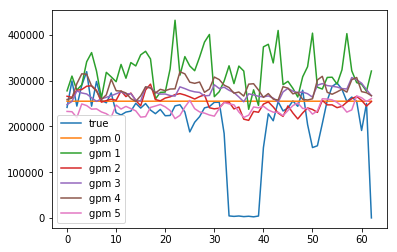

i =  26


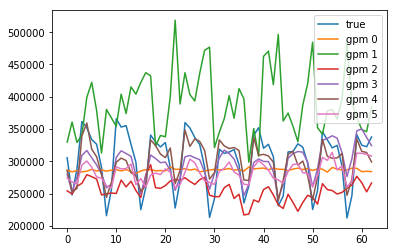

i =  28


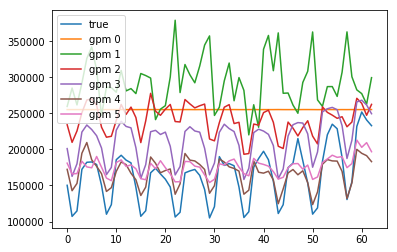

i =  35


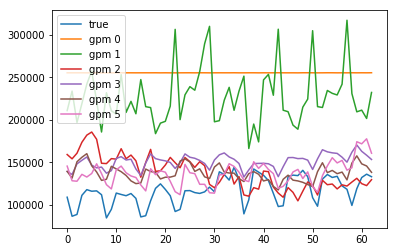

i =  36


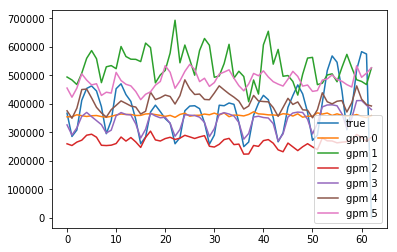

In [224]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [225]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[    8,    26,    28,    35,    36],
       [26500, 66736, 69939, 89202, 90810]])

In [226]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[ 175664.75,  415909.25,  298009.5 ,  123100.75,  355471.75],
       [ 248200.25,  347408.25,  220826.25,  128654.75,  461620.25]], dtype=float32)

#### Group = 4

In [227]:
gp = 4
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [228]:
Y_list.shape

(6, 765, 63)

In [229]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([222, 295, 474, 567, 624])

In [230]:
output_log_std_p = [1.]

Group 4
i =  222


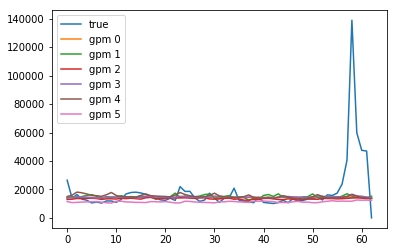

i =  295


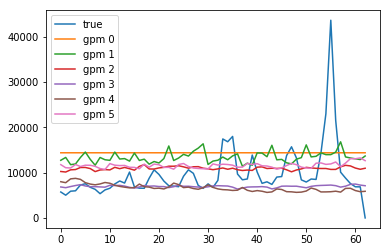

i =  474


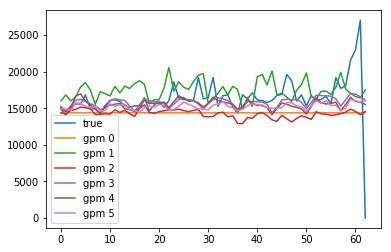

i =  567


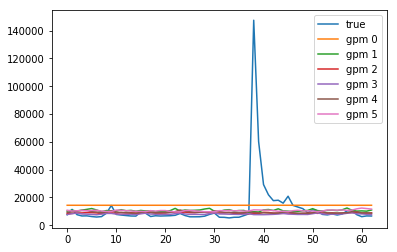

i =  624


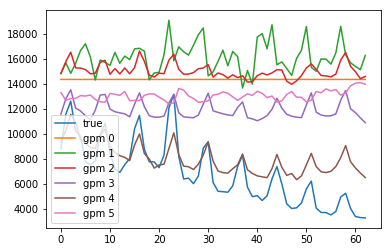

In [231]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

Group 4
i =  222


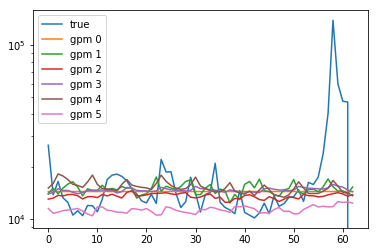

i =  295


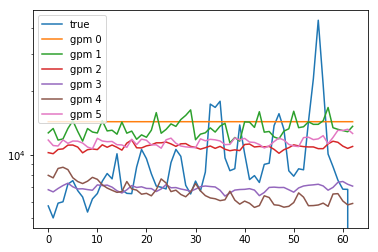

i =  474


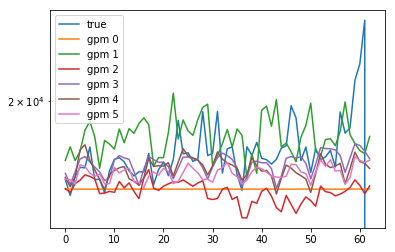

i =  567


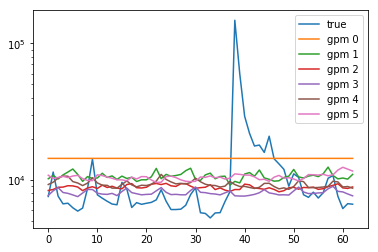

i =  624


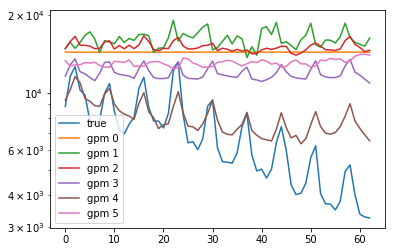

In [232]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.yscale('log')
    plt.legend(); plt.show()    

In [233]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[  222,   295,   474,   567,   624],
       [38655, 39463, 41306, 73183, 75300]])

In [234]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[ 12046.5 ,   9991.5 ,  16615.  ,   5665.5 ,   2425.25],
       [ 11318.75,   8438.  ,  16114.75,   8732.5 ,  13227.5 ]], dtype=float32)

#### Case 131296

In [235]:
i = 131296

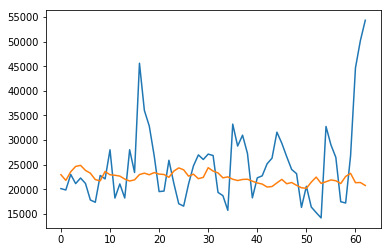

In [236]:
multi_view((Y_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [237]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

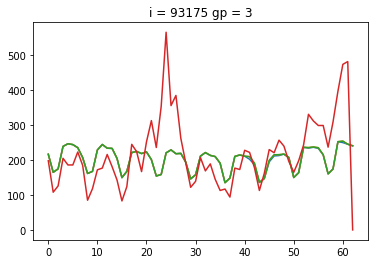

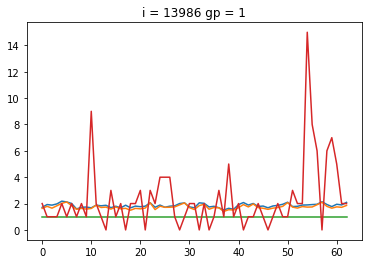

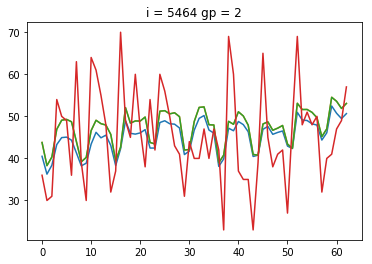

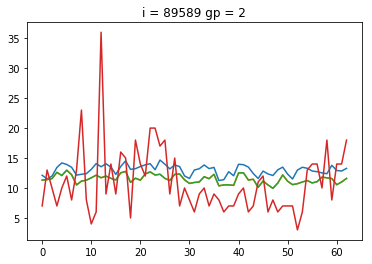

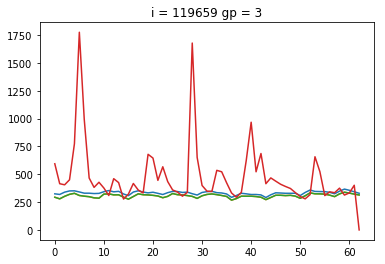

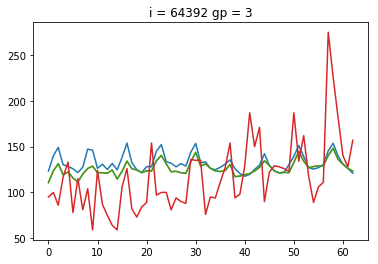

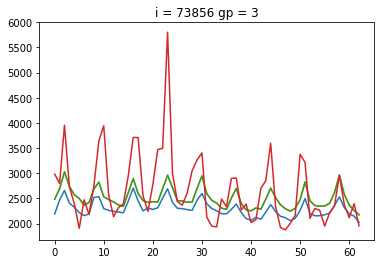

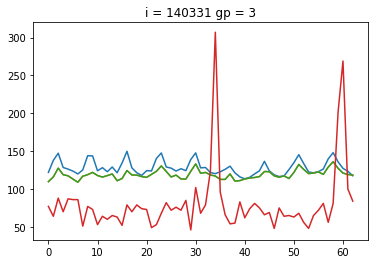

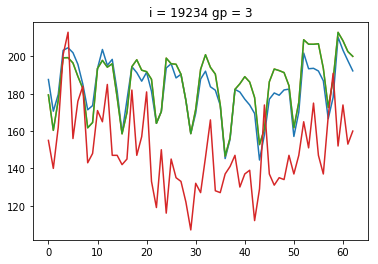

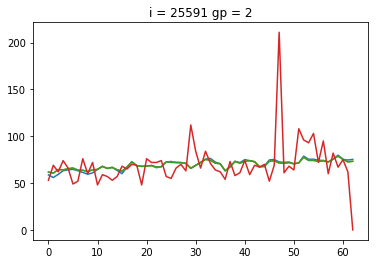

In [238]:
view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                             Y_output_pred_ori_ens_med,
                             Y_output_f_gpm, 
                             Y_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

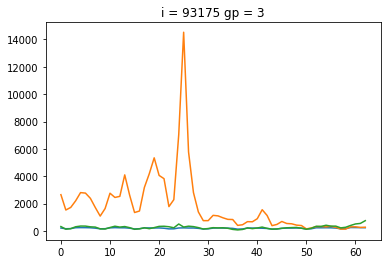

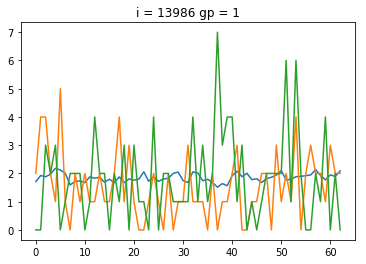

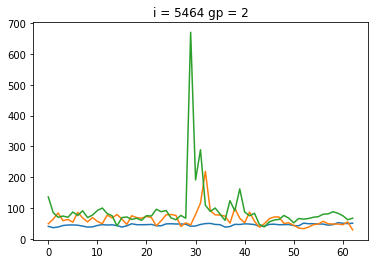

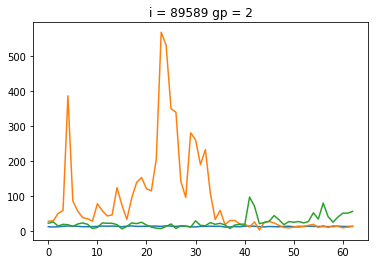

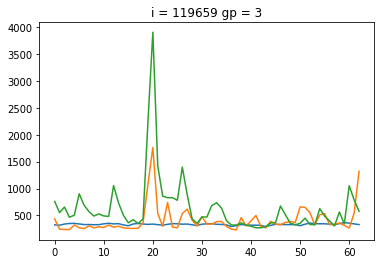

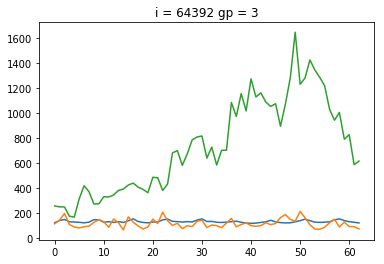

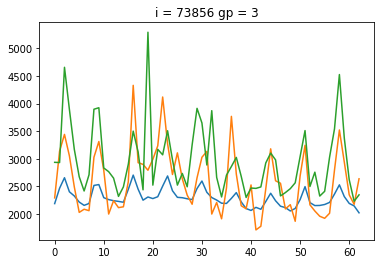

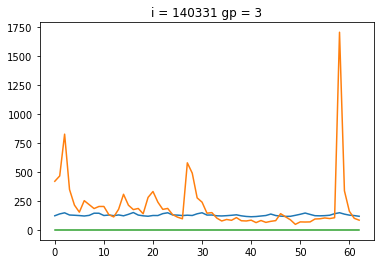

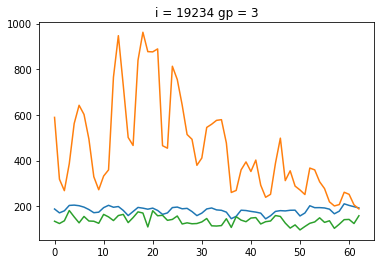

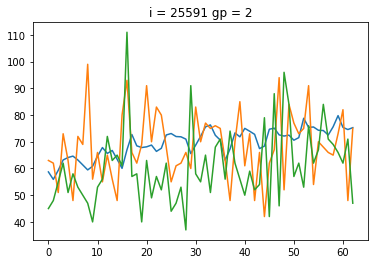

In [239]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

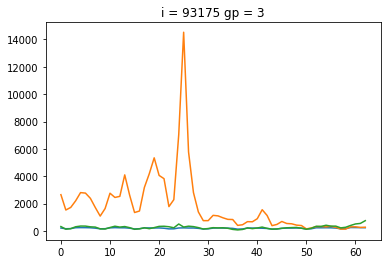

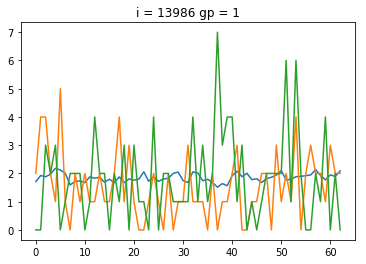

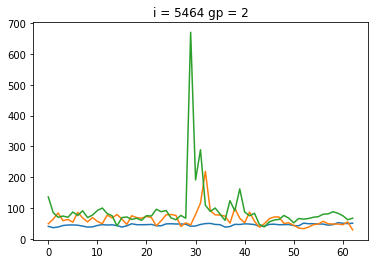

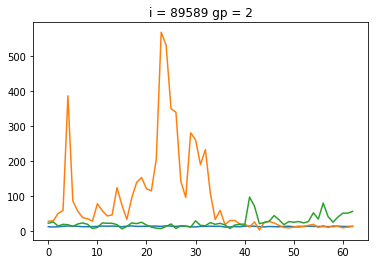

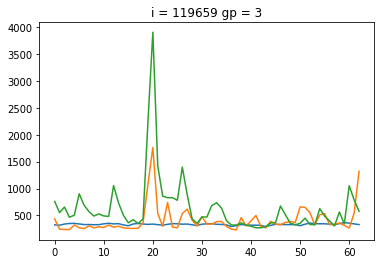

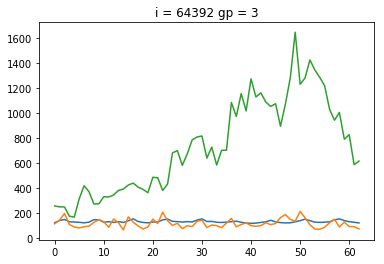

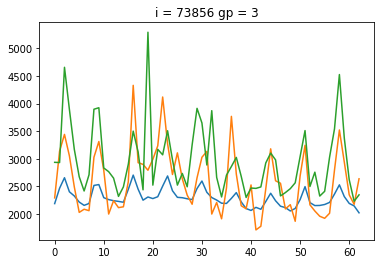

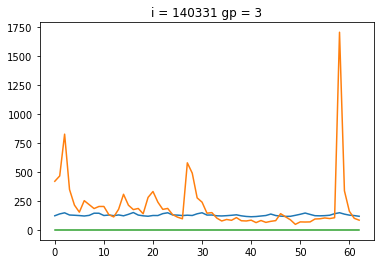

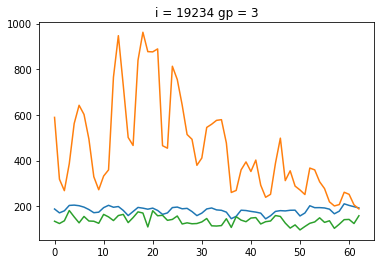

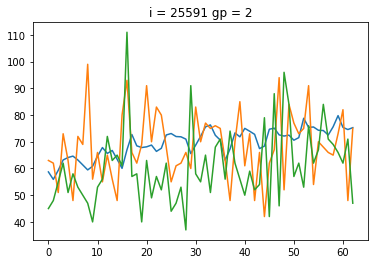

In [240]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(Y_output_center[view_list_good].reshape(-1))
print(Y_output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

Y_input_center[i], Y_output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_Y_input_center = Y_input_center[good_Y_index]
good_Y_output_center = Y_output_center[good_Y_index]
bad_Y_input_center = Y_input_center[bad_Y_index]
bad_Y_output_center = Y_output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (Y_output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, Y_output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, Y_output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / Y_output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (Y_output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [ ]:
Y_output_dates

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_omed, columns = Y_output_dates)  # using ensemble median combined result
result_df

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_2.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_2.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]